# Section 4
Name: Michelle Fong  


## Question 7
### I

In [32]:
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import zero_one_loss, log_loss

data = load_breast_cancer()
x = data.data
y = data.target

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

#### Logistic Model

In [186]:
# fitting logistic model
log_model = LogisticRegression(max_iter=10000)
log_model.fit(x_train, y_train)

# 01 loss: count of misclassification
print('0/1 Loss of Logistic model_train:', round(zero_one_loss(y_train, 
                                                               log_model.predict(x_train)),4))
print('0/1 Loss of Logistic model_test:', round(zero_one_loss(y_test, 
                                                              log_model.predict(x_test)),4))

# log loss: prob(diff from true label)
print('Log Loss of Logistic model_train:', round(log_loss(y_train, 
                                                          log_model.predict_proba(x_train)),4))
print('Log Loss of Logistic model_test:', round(log_loss(y_test, 
                                                         log_model.predict_proba(x_test)),4))

0/1 Loss of Logistic model_train: 0.0361
0/1 Loss of Logistic model_test: 0.1143
Log Loss of Logistic model_train: 0.0761
Log Loss of Logistic model_test: 0.3285


#### Bayesian Classifier

In [187]:
from scipy.stats import multivariate_normal
import numpy as np

class BayesianClassifier:

    def __init__(self, shared_cov=True, cond_ind=True):
        self.shared_cov=shared_cov
        self.cond_ind=cond_ind

    def fit(self, x, y):
        self.classes_, class_counts = np.unique(y, return_counts=True)
        self.n_ , self.p_ = x.shape
        self.k_ = len(self.classes_)
        self.cond_means_ = np.zeros(shape=(self.k_, self.p_))
        self.cond_covs_ = np.zeros(shape=(self.k_, self.p_, self.p_))
        
        self.class_priors_ = class_counts/len(y)
        for c in range(self.k_):
            c_rows = y==c
            self.cond_means_[c, :] = x[c_rows].mean(axis=0)
            
            if self.cond_ind:
                np.fill_diagonal(self.cond_covs_[c, :, :], x[c_rows].var(axis=0))
            else:
                self.cond_covs_[c, :, :] = np.cov(x[c_rows].T, bias=True)

        if self.shared_cov:
            shared_cov = np.moveaxis(self.cond_covs_, 0, -1).dot(self.class_priors_)
            self.cond_covs_[:] = shared_cov

        return self

    def predict_proba(self, x):
        m, _ = x.shape

        # k = number of class
        cond_probs = np.zeros(shape=(m, self.k_))
        for c in range(self.k_):
            # find p(x | c_k)
            # singular covariance matrices could happen (e.g., through inaccurate estimation)
            cond_probs[:, c] = multivariate_normal.pdf(x, 
                                                       self.cond_means_[c],
                                                       self.cond_covs_[c],
                                                       allow_singular=True)
        # find marginal probabilities p(x) by summing all the conditionals weighted by the priors
        marginal_probs = cond_probs.dot(self.class_priors_)

        # find probability vector (p(c1 | x), ..., p(ck | x)) via p(ci | x)=p(x | ci) / p(x)
        # however, p(x) might have been rounded to 0
        # thus, compute via case distinction
        probs = np.divide((cond_probs*self.class_priors_).T,
                          marginal_probs,
                          where=marginal_probs>0, 
                          out=np.zeros(shape=(self.k_, m))).T
        return probs

    def predict(self, x):
        return np.argmax(self.predict_proba(x), axis=1)

    def decision_function(self, x):
        probs = self.predict_proba(x)
        if self.k_ == 2:
            return np.log(probs[:, 1]/probs[:, 0])
        else:
            res = np.zeros(len(x), self.k_)
            for c in range(self.k_):
                res[:, c]=np.log(probs[:, c]/(1-probs[:, c]))
            return res
        
    def generate(self, n, c, random_state=None):
        return multivariate_normal.rvs(self.cond_means_[c], self.cond_covs_[c], size=n, random_state=random_state)

In [188]:
# Naive Bay (shared / not shared conditional covariance) | conditional indepedent input
nbs2 = BayesianClassifier(shared_cov=True, cond_ind=True).fit(x_train, y_train)
nb2 = BayesianClassifier(shared_cov=False, cond_ind=True).fit(x_train, y_train)

# Bay Classifier (shared / not shared conditional covariance) 
bcs2 = BayesianClassifier(shared_cov=True, cond_ind=False).fit(x_train, y_train)
bc2 = BayesianClassifier(shared_cov=False, cond_ind=False).fit(x_train, y_train)


In [193]:
# 01 loss: count of misclassification
print('0/1 Loss of Logistic train:', round(zero_one_loss(y_train, 
                                                               log_model.predict(x_train)),4))
print('0/1 Loss of Logistic test:', round(zero_one_loss(y_test, 
                                                              log_model.predict(x_test)),4))

# log loss: prob(diff from true label)
print('Log Loss of Logistic train:', round(log_loss(y_train, 
                                                          log_model.predict_proba(x_train)),4))
print('Log Loss of Logistic test:', round(log_loss(y_test, 
                                                         log_model.predict_proba(x_test)),4))

print('=============')

# NB shared cov
print('0/1 Loss of NB (shared) train:', round(zero_one_loss(y_train, 
                                                              nbs2.predict(x_train)),4))
print('0/1 Loss of NB (shared) test:', round(zero_one_loss(y_test, 
                                                             nbs2.predict(x_test)),4))

print('Log Loss of NB (shared) train:', round(log_loss(y_train, 
                                                         nbs2.predict_proba(x_train)),4))
print('Log Loss of NB (shared) test:', round(log_loss(y_test, 
                                                        nbs2.predict_proba(x_test)),4))

print('=============')

# NB not shared cov
print('0/1 Loss of NB train:', round(zero_one_loss(y_train, 
                                                                  nb2.predict(x_train)),4))
print('0/1 Loss of NB test:', round(zero_one_loss(y_test, 
                                                                 nb2.predict(x_test)),4))

print('Log Loss of NB train:', round(log_loss(y_train, 
                                                             nb2.predict_proba(x_train)),4))
print('Log Loss of NB test:', round(log_loss(y_test, 
                                                            nb2.predict_proba(x_test)),4))

print('=============')

# BC shared cov
print('0/1 Loss of BC (shared) train:', round(zero_one_loss(y_train, 
                                                              bcs2.predict(x_train)),4))
print('0/1 Loss of BC (shared) test:', round(zero_one_loss(y_test, 
                                                             bcs2.predict(x_test)),4))

print('Log Loss of BC (shared) train:', round(log_loss(y_train, 
                                                         bcs2.predict_proba(x_train)),4))
print('Log Loss of BC (shared) test:', round(log_loss(y_test, 
                                                        bcs2.predict_proba(x_test)),4))

print('=============')

# BC not shared cov
print('0/1 Loss of BC train:', round(zero_one_loss(y_train, 
                                                                  bc2.predict(x_train)),4))
print('0/1 Loss of BC test:', round(zero_one_loss(y_test, 
                                                                 bc2.predict(x_test)),4))

print('Log Loss of BC train:', round(log_loss(y_train, 
                                                             bc2.predict_proba(x_train)),4))
print('Log Loss of BC test:', round(log_loss(y_test, 
                                                            bc2.predict_proba(x_test)),4))


0/1 Loss of Logistic train: 0.0361
0/1 Loss of Logistic test: 0.1143
Log Loss of Logistic train: 0.0761
Log Loss of Logistic test: 0.3285
0/1 Loss of NB (shared) train: 0.0521
0/1 Loss of NB (shared) test: 0.0714
Log Loss of NB (shared) train: 0.591
Log Loss of NB (shared) test: 0.6946
0/1 Loss of NB train: 0.0681
0/1 Loss of NB test: 0.0714
Log Loss of NB train: 1.3327
Log Loss of NB test: 1.2925
0/1 Loss of BC (shared) train: 0.0381
0/1 Loss of BC (shared) test: 0.0857
Log Loss of BC (shared) train: 0.0917
Log Loss of BC (shared) test: 0.2683
0/1 Loss of BC train: 0.0561
0/1 Loss of BC test: 0.1143
Log Loss of BC train: 1.2373
Log Loss of BC test: 2.1673


In [194]:
import matplotlib.pyplot as plt

def plot_model_performances(models, model_names, 
                            x_train, y_train, 
                            x_test, y_test):
    train_01_losses = []
    train_log_losses = []
    test_01_losses = []
    test_log_losses = []

    for i, model in enumerate(models):
        train_log_losses.append(log_loss(y_train, model.predict_proba(x_train)))
        test_log_losses.append(log_loss(y_test, model.predict_proba(x_test)))

        train_01_losses.append(zero_one_loss(y_train, model.predict(x_train)))
        test_01_losses.append(zero_one_loss(y_test, model.predict(x_test)))
        

    xx = np.arange(len(models))
    bar_width = 1/(len(models)+1)
    group_width = len(models)*bar_width
    
    plt.bar(xx-group_width/2, train_log_losses, 
            width=bar_width, label='log loss (train)')
    plt.bar(xx-group_width/2 + bar_width, test_log_losses, 
            width=bar_width, label='log loss (test)')
    
    plt.bar(xx-group_width/2 + 2*bar_width, train_01_losses, 
            width=bar_width, label='0/1 loss (train)')
    plt.bar(xx-group_width/2 +3*bar_width, test_01_losses, 
            width=bar_width, label='0/1 loss (test)')
    plt.xticks(xx, model_names)

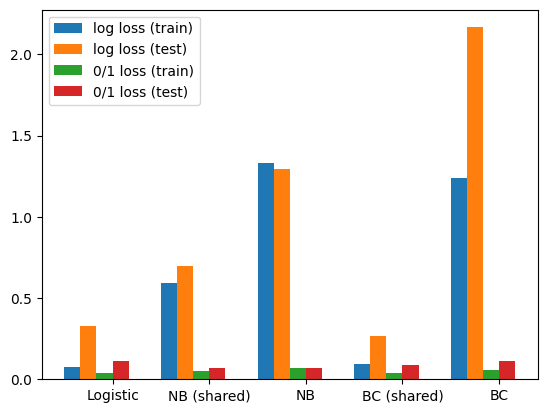

In [195]:
models = [log_model, nbs2, nb2, bcs2, bc2]
model_names = ['Logistic', 'NB (shared)', 'NB', 'BC (shared)', 'BC']

plot_model_performances(models, model_names, x_train, y_train, x_test, y_test)
plt.legend()
plt.show()

From above plot, Logistic model and Bayesian Classifier with shared covariance perform better. They both have a low 0/1 loss which means the model has less misclassification and a low log loss, meaning the probability of having wrong prediction is low. 

Both models have a good perforamnce in training and testing although BC(shared) seems to have a slightly better result in log loss test error. But this result is only specific to this training and testing dataset and the difference in performance between these 2 models are not big.

For the other 3 models, they have a low 01 loss but a high log loss. This means they can accurately preedict the true label but have trouble providing the probaility. 

Notice that the NB model has a lower training log loss compared to the testing error. Possible reasons could be related to the way data splited and the model assumption. NB model assume conditional independent input, if the assumption hold in testing set only, the loss in testing set will be lower. If the training set contains more complex pattern, then it is possible to observe a higher training loss. If this problem is severe, the model may even be overfitted. Since this problem is mainly caused by the way of data splitting, an easy solution is to perform cross validation and repeat building the model with different splitted data. 

On the other hand, BC shows sign of overfitting with its low 0/1 error, high log loss and the log loss in testing is much higher than training set. This is becuase the model is overfitted to the training set and hence fail to predict the testing set true label.



### II
For this part, the requirement is to fit the 5 models above 10 times for each iteration of changing training size. 

In [126]:
training_sizes = list(range(5, 501, 5))
model_names

['Logistic', 'NB (shared)', 'NB', 'BC (shared)', 'BC']

In [131]:
data = load_breast_cancer()
x = data.data
y = data.target

num_repetitions=10
results = {
    'training_size': [],
    'repetition': [],
    'model': [],
    'train_01_loss': [],
    'test_01_loss': [],
    'train_log_loss': [],
    'test_log_loss': []
}
for n_idx, N in enumerate(training_sizes):
    # sample 10 reps for each training size
    for rep in range(num_repetitions):
        print(f'Training size: {N}, Repetition: {rep + 1}/{num_repetitions}')
        
        # split data 
        test_size = 1.0 - (N / len(x))
        x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                            test_size=test_size, shuffle=True)

        # ['Logistic', 'NB (shared)', 'NB', 'BC (shared)', 'BC']
        for model_name in model_names:
            # fit and store its metric score
            if model_name == 'Logistic':
                log_model = LogisticRegression(max_iter=10000)
                log_model.fit(x_train, y_train)
                
                train_01 = zero_one_loss(y_train, log_model.predict(x_train))
                test_01 = zero_one_loss(y_test, log_model.predict(x_test))
                
                train_log = log_loss(y_train, log_model.predict_proba(x_train))
                test_log = log_loss(y_test, log_model.predict_proba(x_test))

                results['training_size'].append(N)
                results['repetition'].append(rep + 1)
                results['model'].append(model_name)
                results['train_01_loss'].append(train_01)
                results['test_01_loss'].append(test_01)
                results['train_log_loss'].append(train_log)
                results['test_log_loss'].append(test_log)
                
            else:
                # each BC model 
                if model_name == 'NB (shared)':
                    bayes_classifier = BayesianClassifier(shared_cov=True, cond_ind=True)
                elif model_name == 'NB':
                    bayes_classifier = BayesianClassifier(shared_cov=False, cond_ind=True)
                elif model_name == 'BC (shared)':
                    bayes_classifier = BayesianClassifier(shared_cov=True, cond_ind=False)
                elif model_name == 'BC':
                    bayes_classifier = BayesianClassifier(shared_cov=False, cond_ind=False)

                # fit BC models 
                bayes_classifier.fit(x_train, y_train)

                # store the metrics scores
                train_01 = zero_one_loss(y_train, bayes_classifier.predict(x_train))
                test_01 = zero_one_loss(y_test, bayes_classifier.predict(x_test))
                train_log = log_loss(y_train, bayes_classifier.predict_proba(x_train))
                test_log = log_loss(y_test, bayes_classifier.predict_proba(x_test))
            
            # store 4 metrics scores into the results_array
                results['training_size'].append(N)
                results['repetition'].append(rep + 1)
                results['model'].append(model_name)
                results['train_01_loss'].append(train_01)
                results['test_01_loss'].append(test_01)
                results['train_log_loss'].append(train_log)
                results['test_log_loss'].append(test_log)

Training size: 5, Repetition: 1/10
Training size: 5, Repetition: 2/10
Training size: 5, Repetition: 3/10
Training size: 5, Repetition: 4/10
Training size: 5, Repetition: 5/10
Training size: 5, Repetition: 6/10
Training size: 5, Repetition: 7/10
Training size: 5, Repetition: 8/10
Training size: 5, Repetition: 9/10
Training size: 5, Repetition: 10/10
Training size: 10, Repetition: 1/10
Training size: 10, Repetition: 2/10
Training size: 10, Repetition: 3/10
Training size: 10, Repetition: 4/10
Training size: 10, Repetition: 5/10
Training size: 10, Repetition: 6/10
Training size: 10, Repetition: 7/10
Training size: 10, Repetition: 8/10
Training size: 10, Repetition: 9/10
Training size: 10, Repetition: 10/10
Training size: 15, Repetition: 1/10
Training size: 15, Repetition: 2/10
Training size: 15, Repetition: 3/10
Training size: 15, Repetition: 4/10
Training size: 15, Repetition: 5/10
Training size: 15, Repetition: 6/10
Training size: 15, Repetition: 7/10
Training size: 15, Repetition: 8/10


### III

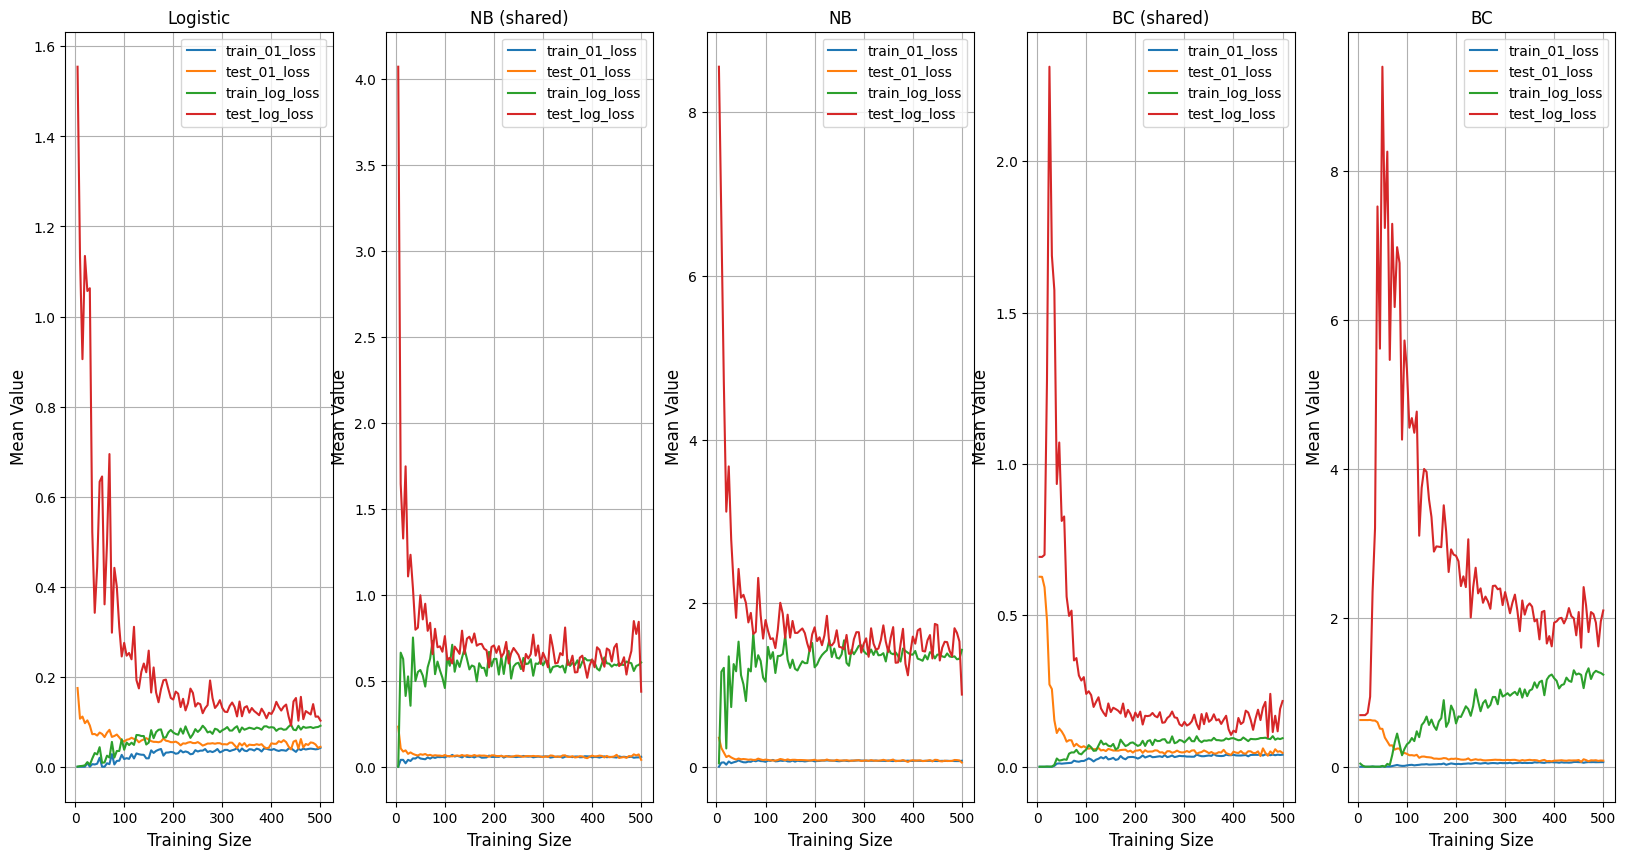

In [172]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_metrics_vs_training_size(results_df, model_names, metrics, training_sizes):
    fig, axes = plt.subplots(1, len(model_names), figsize=(20, 10))

    for i, model_name in enumerate(model_names):
        ax = axes[i]
        ax.set_title(model_name)

        # filter by model
        filter_model = results_df[results_df['model'] == model_name]

        # loop thr each model
        for metric_name in metrics:
            metric_values = []

            # filter by training size
            for N in training_sizes:
                # Filter by current training size
                filter_size = filter_model[filter_model['training_size'] == N]

                # average over 10 repetitions 
                metric_mean = filter_size[metric_name].mean()
                metric_values.append(metric_mean)

            # plot average metric vs training size, coloured by metric
            ax.plot(training_sizes, metric_values, label=metric_name)

        ax.set_xlabel('Training Size', fontsize=12)
        ax.set_ylabel('Mean Loss Value', fontsize=12)
        ax.legend()
        ax.grid(True)

    plt.show()

results_df = pd.DataFrame(results)
# metrics = column name of results_df
metrics = ['train_01_loss', 'test_01_loss', 'train_log_loss', 'test_log_loss']

plot_metrics_vs_training_size(results_df, model_names, metrics, training_sizes)


In [135]:
results_df

,training_size,repetition,model,train_01_loss,test_01_loss,train_log_loss,test_log_loss
0,5,1,Logistic,0.000000,0.117021,1.400893e-05,0.416436
1,5,1,NB (shared),0.000000,0.122340,2.220446e-16,3.220839
2,5,1,NB,0.000000,0.225177,2.220446e-16,7.554780
3,5,1,BC (shared),0.000000,0.629433,2.220446e-16,0.693147
4,5,1,BC,0.000000,0.629433,2.220446e-16,0.693147
...,...,...,...,...,...,...,...
4995,500,10,Logistic,0.036072,0.114286,7.610055e-02,0.328472
4996,500,10,NB (shared),0.052104,0.071429,5.910188e-01,0.694571
4997,500,10,NB,0.068136,0.071429,1.332721e+00,1.292491
4998,500,10,BC (shared),0.038076,0.085714,9.167007e-02,0.268279


### III

After repeating for 10 times for each training size, we can more confirm that Logistic model performs the best, followed by BC(shared cov) as their mean value of error are must lower compared to other 3. Since 01 loss and log loss are similar loss function, change in error using 01 loss and log log are similar. 01 loss count the number of missclassifications while log loss measure the probability of different from true label.     

a & c)  
To summarise, all 5 models train errors increase and test error decrease as the training size increase.    

For all 5 models, their test losses are high regardless of metrics used when training set is small. This aligns with the expectation as small training set has limited information to be fully explored and therefore the full picutre cannot be observed. But even with a small training set, Logistic and BC(shared) have a lower mean error compared to other 3 models.  

Their train error increaese graduately with the training size and flatten out with a relatively small training size compared to other models. The drop in test errors are also larger comparatively.  

NB models have highest increase in training error when training size small and become stable when the size is large over 300. When the size reach around 500, the test error decrease over train error, showing signs of overfitting.

For the BC model, the train error is still quite high after increase training set size. More training data or iterations might be needed to lower the error as it does not coverge fast enough.

One reason is the bias-variance tradeoff. When training size started off small, the bias is high but the variance is low as the model is specific to the training set used. Therefore the training error increase rapidly as the training size increase by a bit due to the variability introduced with different samples. Eventually it will stable and balance betwee bias and variance.

b & c)  
With a small training size, model with less parameters will fit better as the model is simpler and have less parameters to be estimated. This also helps to prevent overfitting. This can be observed from the plot since NB already overfitted when size is around 500. Logistics and BC(shared) seem to perform better than other model when training size small. BC(shared) assume all classes have the same covariance which reduce the model complexity a lot and make it more suitable for small amount of data.  

With large training size, BC is best suited as it assumes non-sharing covariance so each covariance would have to be estimated. Therefore there are many parameters to be estimated with a very complex model. More data is requried to make prediction. It is less likely to be overfitted and would be able to capture underlying pattern better.



c)
Another factor causing above result is the assumption of the model. Naive Bayes Model assume independent between features. If this assumption fails to be justified, it explains why NB models performance are worse.